In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import (losses, metrics, models, callbacks, layers, utils, optimizers, )

from IPython.display import Image, display

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
2024-03-22 11:06:31.380233: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-22 11:06:31.380331: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-22 11:06:31.436412: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered

In [2]:
train_data = utils.image_dataset_from_directory("Lego Bricks Dataset/dataset", 
                                               interpolation='bilinear',
                                               labels = None,
                                               color_mode='grayscale',
                                               image_size=(64,64),
                                               batch_size=128,
                                               shuffle=True,
                                               seed=42)

def preprocess(img):
    img = (tf.cast(img,"float32") - 127.5) / 127.5
    return img

train = train_data.map(lambda x : preprocess(x))
display(train)

Found 40000 files belonging to 1 classes.


2024-03-22 11:06:39.553588: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-22 11:06:39.690166: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-22 11:06:39.690218: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-22 11:06:39.692528: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-22 11:06:39.692594: I external/local_xla/xla/stream_executor

<_MapDataset element_spec=TensorSpec(shape=(None, 64, 64, 1), dtype=tf.float32, name=None)>

In [3]:
#the discriminator

discriminator_input = layers.Input(shape=(64,64,1))
x = layers.Conv2D(filters=64, kernel_size=4, strides=2, padding='same',use_bias=False)(discriminator_input)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(filters=128, kernel_size=4, strides=2, padding='same', use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(filters=256, kernel_size=4, strides=2, padding='same', use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(filters=512, kernel_size=4, strides=2, padding='same', use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(filters=1, kernel_size=4, strides=1, padding="valid", use_bias=True, activation="sigmoid")(x)
discriminator_output = layers.Flatten()(x)
discriminator = models.Model(discriminator_input, discriminator_output)
discriminator.summary()

# the Generator

generator_input = layers.Input(shape=(100,))
x = layers.Reshape((1,1,100))(generator_input)
x = layers.Conv2DTranspose(512, kernel_size=4, strides=1, padding="valid", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.UpSampling2D(size=2)(x)
x = layers.Conv2D(256, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.UpSampling2D(size=2)(x)
x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.UpSampling2D(size=2)(x)
x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
generator_output = layers.Conv2DTranspose(1, kernel_size=4, strides=2, padding="same", use_bias=False, activation="tanh")(x)
generator = models.Model(generator_input, generator_output)
generator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1024      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131072    
                                                                 
 batch_normalization (Batch  (None, 16, 16, 128)       512       
 Normalization)                                                  
                                                             

In [4]:
class DCGAN(models.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer):
        super(DCGAN, self).compile()
        self.loss_fn = losses.BinaryCrossentropy()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_metric = metrics.Mean(name="d_loss")
        self.d_real_acc_metric = metrics.BinaryAccuracy(name="d_real_acc")
        self.d_fake_acc_metric = metrics.BinaryAccuracy(name="d_fake_acc")
        self.d_acc_metric = metrics.BinaryAccuracy(name="d_acc")
        self.g_loss_metric = metrics.Mean(name="g_loss")
        self.g_acc_metric = metrics.BinaryAccuracy(name="g_acc")

    @property
    def metrics(self):
        return [
            self.d_loss_metric,
            self.d_real_acc_metric,
            self.d_fake_acc_metric,
            self.d_acc_metric,
            self.g_loss_metric,
            self.g_acc_metric,
        ]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(random_latent_vectors, training=True)
            real_predictions = self.discriminator(real_images, training=True)
            fake_predictions = self.discriminator(generated_images, training=True)
            real_labels = tf.ones_like(real_predictions)
            real_noisy_labels = real_labels + 0.1 * tf.random.uniform(tf.shape(real_predictions))
            fake_labels = tf.zeros_like(fake_predictions)
            fake_noisy_labels = fake_labels - 0.1 * tf.random.uniform(tf.shape(fake_predictions))
            d_real_loss = self.loss_fn(real_noisy_labels, real_predictions)
            d_fake_loss = self.loss_fn(fake_noisy_labels, fake_predictions)
            d_loss = (d_real_loss + d_fake_loss) / 2.0
            g_loss = self.loss_fn(real_labels, fake_predictions)
        gradients_of_discriminator = disc_tape.gradient(d_loss, self.discriminator.trainable_variables)
        gradients_of_generator = gen_tape.gradient(g_loss, self.generator.trainable_variables )
        self.d_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        self.g_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        self.d_loss_metric.update_state(d_loss)
        self.d_real_acc_metric.update_state(real_labels, real_predictions)
        self.d_fake_acc_metric.update_state(fake_labels, fake_predictions)
        self.d_acc_metric.update_state([real_labels, fake_labels], [real_predictions, fake_predictions])
        self.g_loss_metric.update_state(g_loss)
        self.g_acc_metric.update_state(real_labels, fake_predictions)

        return {m.name: m.result() for m in self.metrics}
    
dcgan = DCGAN(discriminator=discriminator, generator=generator, latent_dim=100)

In [5]:
if False:
    dcgan.load_weights("checkpoint/checkpoint.ckpt")

dcgan.compile(d_optimizer=optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.999),
             g_optimizer=optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.999),)

model_checkpoint_callback = callbacks.ModelCheckpoint(filepath="checkpoint/checkpoint.ckpt",
                                                      save_freq="epoch",
                                                      save_weights_only=True,
                                                      verbose=0)
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()
        #display(generated_images, f"./output/generated_img_{epoch:.3d}.png",)

In [6]:
#using steps_per_epoch=1 is optional, it makes training faster in less time but generates less accurate results
dcgan.fit(train, epochs = 300, callbacks=[model_checkpoint_callback, tensorboard_callback, ImageGenerator(num_img=10, latent_dim=100)])

Epoch 1/300


2024-03-22 11:06:57.264347: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-03-22 11:06:57.723016: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-22 11:06:58.025383: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-22 11:07:01.680175: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f3336656980 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-22 11:07:01.680218: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-03-22 11:07:01.692650: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer,

313/313 [==============================] - 101s 284ms/step - d_loss: 0.4957 - d_real_acc: 0.7652 - d_fake_acc: 0.7746 - d_acc: 0.7699 - g_loss: 2.4852 - g_acc: 0.2254
Epoch 2/300
313/313 [==============================] - 84s 269ms/step - d_loss: 0.2302 - d_real_acc: 0.8383 - d_fake_acc: 0.8601 - d_acc: 0.8492 - g_loss: 2.8757 - g_acc: 0.1399
Epoch 3/300
313/313 [==============================] - 84s 269ms/step - d_loss: 0.1313 - d_real_acc: 0.8690 - d_fake_acc: 0.8824 - d_acc: 0.8757 - g_loss: 3.6364 - g_acc: 0.1176
Epoch 4/300
313/313 [==============================] - 84s 269ms/step - d_loss: 0.0260 - d_real_acc: 0.8971 - d_fake_acc: 0.9189 - d_acc: 0.9080 - g_loss: 4.3381 - g_acc: 0.0811
Epoch 5/300
313/313 [==============================] - 86s 274ms/step - d_loss: -0.0097 - d_real_acc: 0.9098 - d_fake_acc: 0.9241 - d_acc: 0.9170 - g_loss: 5.4072 - g_acc: 0.0759
Epoch 6/300
313/313 [==============================] - 85s 270ms/step - d_loss: -0.0928 - d_real_acc: 0.9186 - d_fake_ac

1/1 [==============================] - 1s 1s/step


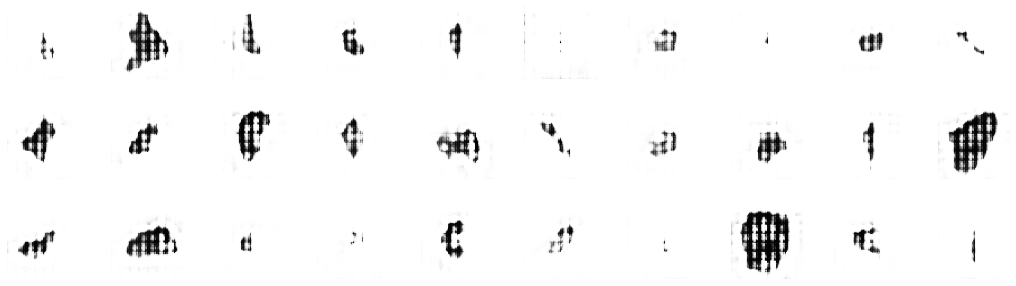

In [7]:
grid_width, grid_height = (10,3)
z_sample = np.random.normal(size=(grid_width * grid_height, 100))

reconstructions = generator.predict(z_sample)

fig = plt.figure(figsize=(18,5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i+1)
    ax.axis("off")
    ax.imshow(reconstructions[i,:,:], cmap="Greys")

1/1 [==============================] - 1s 1s/step


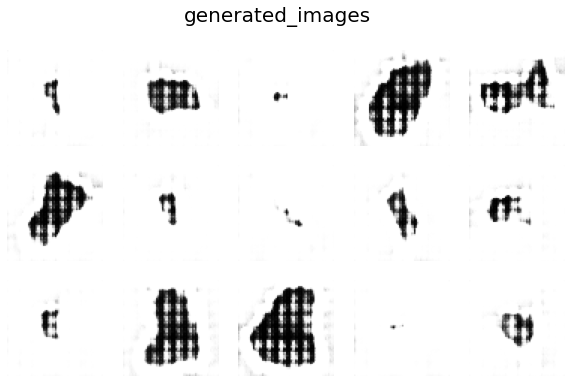

In [8]:
def compare_images(img1, img2):
    return np.mean(np.abs(img1 - img2))

all_data = []
for i in train.as_numpy_iterator():
    all_data.extend(i)
all_data = np.array(all_data)

r,c = 3,5
fig, axs = plt.subplots(r,c,figsize=(10,6))
fig.suptitle("generated_images", fontsize=20)
noise = np.random.normal(size=(r * c, 100))
gen_imgs = generator.predict(noise)
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow(gen_imgs[cnt], cmap="gray_r")
        axs[i,j].axis("off")
        cnt += 1
plt.show()

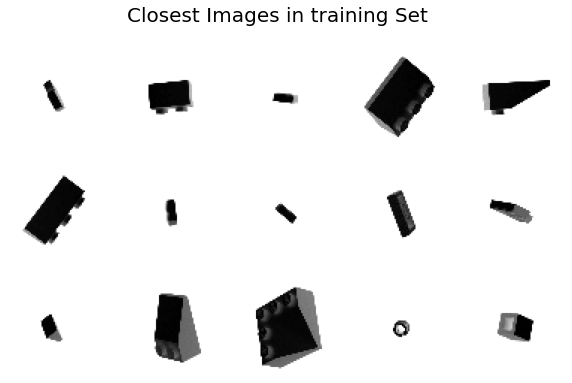

In [9]:
fig, axs = plt.subplots(r,c,figsize=(10,6))
fig.suptitle("Closest Images in training Set", fontsize=20)
cnt=0
for i in range(r):
    for j in range(c):
        c_diff = 99999
        c_img = None
        for k_idx, k in enumerate(all_data):
            diff = compare_images(gen_imgs[cnt], k)
            if diff < c_diff:
                c_img = np.copy(k)
                c_diff = diff
        axs[i,j].imshow(c_img, cmap="gray_r")
        axs[i,j].axis("off")
        cnt += 1
plt.show()

In [10]:
discriminator.save("models/dcgan_discminator.h5")
generator.save("models/dcgan_generator.h5")

In [11]:
dcgan.history.history.keys()

dict_keys(['d_loss', 'd_real_acc', 'd_fake_acc', 'd_acc', 'g_loss', 'g_acc'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


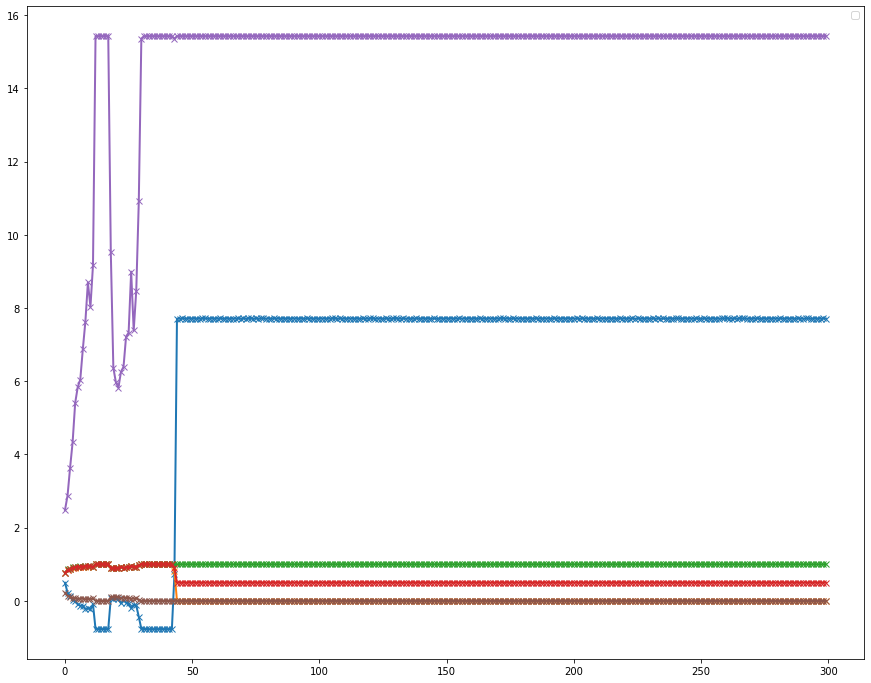

In [12]:
plt.figure(figsize=(15,12))
for i in ['d_loss', 'd_real_acc', 'd_fake_acc', 'd_acc', 'g_loss', 'g_acc']:
    plt.plot(dcgan.history.history[i], linewidth=2, marker='x')
    plt.gca()
plt.legend()
plt.show()